# Advanced Blobs: reducing them

Often we're not interested to really store all of the blobs returned from the likelihood function.  Instead we want to process it, often reductions using something like [OnlineStats.jl](https://github.com/joshday/OnlineStats.jl) may be useful.

This follows the previous example [bayesian-ex-predictions.ipynb](bayesian-ex-predictions.ipynb), up to the cell "Blobs in the posterior" exactly.   But then, instead of storing all the prediction values, stores mean, standard deviation, max/min, and 80 quatiles.

## Making predictions, aka how to use blobs.

As far as I can tell, there are two types of predictions:

- (a) predict (x,v) of the true state of the system at t
- (b) predict (x,v) of what a measurement would yield at approx t

How to do it:

- (a) is done by evaluating the forward model at t to get samples of (x,v)
- (b) is done by drawing a sample (t,x,v) from the likelihood for all given theta

Implementation:

- (a) can be implemented by returning a [blob](http://dan.iel.fm/emcee/current/user/advanced/#arbitrary-metadata-blobs) from the pdf containing the (x,v) at the desired ts.
- (b) is a bit harder.  I think it goes like this: for a given theta, draw a t_p with error sigma_t, evaluate fwd(theta, t_d)->(x,v). Draw an x_p, y_p with sigma_x,sigma-v.

  0.000003 seconds (148 allocations: 10.151 KB)


    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.


[Plots.jl] Initializing backend: pyplot



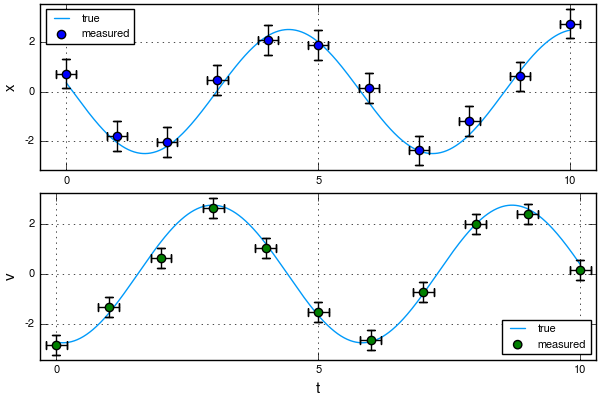

In [1]:
using NBInclude
nbinclude("bayesian-ex-base.ipynb")

using Plots,StatPlots # this works only up to StatPlots 9e665438 & on 0.5 of PyCall too (14 July 2016)
# choose to use the analytic or ODE-forward model
fwd! = [fwd_ana!, fwd_ode!][1]
@time 1 # warmup

# make the synthetic measurements
fac = 1
sigma_x = 0.3 *fac
sigma_v = 0.2 *fac
sigma_t = 0.1 *fac
const ts_measured, xv_measured, A, ω, ϕ, ts_true, xv_true = make_synthetic_measurements(theta_true = [2.5, 1.1, 3], # [A, ω, ϕ]
                                                                                        sigma_x=sigma_x,
                                                                                        sigma_v=sigma_v,
                                                                                        sigma_t=sigma_t)
@assert !all(ts_measured.==ts_true)

## Plot the measurements
plotmeasurements(ts_measured,xv_measured,A,ω,ϕ,sigma_x=sigma_x,sigma_v=sigma_v,sigma_t=sigma_t)

## Probabilistic model setup

Fitting parameters `[A,ω,ϕ,sigma_x,sigma_v,sigma_t,ts] = theta`

Predict (x,y) (a) and (b) at `ts_pred` times.

In [2]:
################
# Predict (x,y) (a) and (b) at these locations
ts_pred = [5.0, 8.5, 15, 30, 100, 1e4]
# I do this below by returning a blob of x,v values
# [x,v,x,v,...]

const fwdout = init_fwd(ts_measured) # Note, this will be modified in place
const fwdout_pred = init_fwd(ts_pred); # Note, this will be modified in place

varnames = vcat(["A","ω",  "ϕ",  "σ_x", "σ_v", "σ_t"], ["t$i" for i=1:length(ts_measured)])

getts(theta) = view(theta, 7:length(ts_measured)+6)

# Treat ts as measurements too
function loglikelihood(fwdout, ts, xv_measured, ts_measured, sigma_x,sigma_v,sigma_t)
    out = zero(err1(xv_measured[1], fwdout[1]))
    N = length(xv_measured)

    # Note the normalization term 1/2*log(2*pi*sigma^2) needs to
    # be included when sigma is also a fitting parameter.
    for i=1:2:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma_x^2) + log(2*pi*sigma_x^2)
    end
    for i=2:2:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma_v^2) + log(2*pi*sigma_v^2)
    end
    # treat time as measurements too
    for i=1:length(ts)
        out -= err1(ts_measured[i], ts[i])/(sigma_t^2) + log(2*pi*sigma_t^2)
    end
    return out/2
end

# Normal & uniform priors
logprior_A(A) = 0<=A ? 0.0 : -Inf # amplitude is positive
ω_max = 15.0
logprior_ω(ω) = 0<=ω<ω_max ? 0.0 : -Inf # ω is bounded
logprior_ϕ(ϕ) = 0<=ϕ<2*pi ? 0.0 : -Inf # ϕ is bounded

sigma_x_est = 0.2 # our prior estimate of sigma_x
sigma_est_sigma_x = 0.2 # our estimate of the std of sigma_x
logprior_sigma_x(sigma_x) = sigma_x<=0 ? -Inf : -(sigma_x-sigma_x_est)^2/(2*sigma_est_sigma_x^2)

sigma_v_est = 0.2 # our prior estimate of sigma_v
sigma_est_sigma_v = 0.2 # our estimate of the std of sigma_v
logprior_sigma_v(sigma_v) = sigma_v<=0 ? -Inf : -(sigma_v-sigma_v_est)^2/(2*sigma_est_sigma_v^2)

sigma_t_est = 0.05 # our prior estimate of sigma_t
sigma_est_sigma_t = 0.05 # our estimate of the std of sigma_t
logprior_sigma_t(sigma_t) = sigma_t<=0 ? -Inf : -(sigma_t-sigma_t_est)^2/(2*sigma_est_sigma_t^2)

# TODO: what about priors on ts?
# sum of priors for ts
function logpriors_ts(ts)
    out = 0.0
    for i=1:length(ts)
        out -= (ts[i]-ts_measured[i])^2/(2*sigma_t_est^2)
    end
    return out
end


logprior = (theta) -> (logprior_A(theta[1]) +
                       logprior_ω(theta[2]) +
                       logprior_ϕ(theta[3]) +
                       logprior_sigma_x(theta[4]) +
                       logprior_sigma_v(theta[5]) +
                       logprior_sigma_t(theta[6]) +
                       logpriors_ts(getts(theta))
                       );

## Blobs in the posterior

The posterior now also returns a blob (a arbitraty bit of data), which contains the needes samples for the predictions.   `blob[1:2np]` contains the forward model output at the times in `ts_pred`; `blob[2np+1:end]` contains a sample of what a measurement at those times could yield.

In [3]:
function logposterior_blob(theta)
    # Closure over fwdout, fwdout_pred, xv_measured, ts_measured
    
    # calculate posterior density:
    A,ω,ϕ,sigma_x,sigma_v,sigma_t = theta
    ts = getts(theta)
    fwd!(fwdout, ts, A,ω,ϕ)
    logl = loglikelihood(fwdout, ts, xv_measured, ts_measured, sigma_x,sigma_v,sigma_t)
    density = logl + logprior(theta)
    # Calculate blob.  Note that if the forward model was more
    # expensive then this should be done more cleverly by only
    # evaluating it simultaneously at the ts_measured and ts_pred.
    np = length(ts_pred)
    blob = zeros(4*np)
    # (a) prediction
    fwd!(fwdout_pred, ts_pred, A,ω,ϕ)
    blob[1:2np] = fwdout_pred
    # (b) prediction
    ts_pred_s = randn(np)*sigma_t + ts_pred # t with errors
    fwd!(fwdout_pred, ts_pred_s, A,ω,ϕ) # fwd-model at those points
    for i=1:np
        # sample x and v
        blob[2np+2i-1] = randn()*sigma_x + fwdout_pred[2i-1]
        blob[2np+2i  ] = randn()*sigma_v + fwdout_pred[2i]
    end
    return density, blob
end;

# Reduce blobs before storage

To safe space (not important in this example, but maybe so if the blobs are big), we now specify a function to process the blob before storing.  Instead of storing all samples at the `ts_pred` times we store the mean, standard deviation, max/min, and some quatiles.  [OnlineStats.jl](https://github.com/joshday/OnlineStats.jl) provides exactly what's needed for this.

In [4]:
using OnlineStats
#  Two methods needed to intitialize the storage-blob:
function blob_reduce!(new_blob, niter::Int, nburnin::Int, nthin::Int)
    n = length(new_blob)
    m = [Moments() for i=1:n]
    T = typeof(QuantileMM(;tau=[0.05, 0.2, 0.5, 0.8, 0.95]))
    q = T[QuantileMM(;tau=[0.05, 0.2, 0.5, 0.8, 0.95]) for i=1:n]
    e = [Extrema() for i=1:n]
    return (m,q,e)
end
blob_reduce!(new_blob, niter::Int, nburnin::Int, nthin::Int, nchains::Int) = 
             [blob_reduce!(new_blob,niter,nburnin,nthin) for i=1:nchains]
# Two methods to update it
function blob_reduce!(stored_blob, new_blob, ni::Int)
    for sb in stored_blob
        for i=1:length(sb)
            fit!(sb[i], new_blob[i])
        end
    end
    nothing
end
blob_reduce!(stored_blob, new_blob, ni::Int, nc::Int) = blob_reduce!(stored_blob[nc], new_blob, ni);

# helper functions:
function unpack_blob(blob, ts_pred)
    n = length(ts_pred)
    # helper functions:
    
    tmp = map(mean, blob[1])
    xv_mean_a = tmp[1:2n]
    xv_mean_b = tmp[2n+1:end]

    tmp = map(std, blob[1])
    xv_std_a = tmp[1:2n]
    xv_std_b = tmp[2n+1:end]

    tmp = map(value, blob[3])
    xv_max_a = [tmp[i][2] for i=1:2n]
    xv_max_b = [tmp[i][2] for i=2n+1:4n]
    xv_min_a = [tmp[i][1] for i=1:2n]
    xv_min_b = [tmp[i][1] for i= 2n+1:4n]
    
    tmp = map(value, blob[2])
    xv_q20_a = [tmp[i][2] for i=1:2n]
    xv_q80_b = [tmp[i][4] for i=2n+1:4n]    
    
    return xv_mean_a, xv_std_a, xv_max_a, xv_min_a, xv_q20_a, xv_q80_b
end;

## MCMC fitting

First define some parameters. Generally `_m` referes to variables connected to the Metropolis sampler, `_e` to the `emcee` sampler.

In [5]:
niter = 5*10^5 # number of MC steps
nthin = 10     # only store theta every so often
nburnin = niter÷3 # how much burn-in
nchains = 50 # number of chains used in the emcee sampler
niter_e = niter÷nchains # iterations in the emcee sampler reduced accordingly
nburnin_e = niter_e÷3;

In [6]:
#################
# Metropolis MCMC
#################

# Using a Gaussian proposal distribution.  Note, this needs to be
# symmetric for Metropolis!

sig = 0.002  # this needs tuning, accept_ratio of 1/4 is good, they say.
const sigma_ppdf = sig*ones(6+length(ts_measured))
sample_ppdf(theta) = [randn()*sigma_ppdf[i]+theta[i] for i=1:length(theta)]

theta_true = vcat([A, ω, ϕ, sigma_x, sigma_v, sigma_t], ts_measured);  # good IC
theta0 = vcat([2.1, 1.1, 1.1, 0.2, 0.2, 0.05], ts_measured); # decent IC

metropolis(logposterior_blob, sample_ppdf, theta0, niter=2, hasblob=true, blob_reduce! = blob_reduce!)
print("Metropolis: ")
@time thetas_m, accept_ratio_m, blobs_m = metropolis(logposterior_blob, sample_ppdf, theta0,
                                                     niter=niter, nthin=nthin, nburnin=nburnin, 
                                                     hasblob=true, blob_reduce! = blob_reduce!)
print_results(thetas_m, accept_ratio_m, names=varnames, title="Metropolis", theta_true=theta_true)

Metropolis:   6.802930 seconds (86.99 M allocations: 1.778 GB, 3.26% gc time)
Metropolis
Ratio of accepted/total steps: 0.6157787684424632

var 	 err	median	 mean 	 mode 	 std
A 	 0.19 	 2.31 	 2.3 	 2.32 	 0.07
ω 	 0.01 	 1.11 	 1.12 	 1.11 	 0.01
ϕ 	 0.08 	 2.92 	 2.91 	 2.95 	 0.06
σ_x 	 0.02 	 0.32 	 0.33 	 0.32 	 0.07
σ_v 	 0.03 	 0.23 	 0.23 	 0.21 	 0.05
σ_t 	 0.08 	 0.02 	 0.02 	 0.0 	 0.01
t1 	 0.0 	 0.0 	 0.0 	 0.0 	 0.02
t2 	 0.0 	 1.0 	 1.0 	 1.0 	 0.02
t3 	 0.0 	 2.0 	 1.99 	 2.0 	 0.02
t4 	 0.0 	 3.0 	 3.0 	 3.0 	 0.02
t5 	 0.0 	 4.0 	 4.0 	 4.0 	 0.02
t6 	 0.0 	 5.0 	 5.0 	 5.0 	 0.02
t7 	 0.0 	 6.0 	 6.0 	 6.0 	 0.02
t8 	 0.0 	 7.0 	 7.0 	 7.0 	 0.02
t9 	 0.0 	 8.0 	 8.0 	 8.0 	 0.02
t10 	 0.0 	 9.0 	 9.0 	 9.0 	 0.02
t11 	 0.0 	 10.0 	 10.0 	 10.0 	 0.02



In [7]:
#################
# emcee MCMC
#################

emcee(logposterior_blob, (theta0, 0.1), niter=10, nchains=2, hasblob=true, blob_reduce! = blob_reduce!)
print("emcee:")
@time thetas_ec, accept_ratio_ec, blobs_ec = emcee(logposterior_blob, (theta0, 0.1),
                                               niter=niter_e, nthin=nthin, nchains=nchains, nburnin=nburnin_e, 
                                               hasblob=true, blob_reduce! = blob_reduce!)
# When running this problem with IC far from the maximum, then emcee produces bad chains which are dropped:
thetas_e, accept_ratio_e, blobs_e = squash_chains(thetas_ec, accept_ratio_ec, blobs_ec, drop_low_accept_ratio=true)
print_results(thetas_e, accept_ratio_e, names=varnames, title="emcee", theta_true=theta_true)

emcee:  7.291133 seconds (90.40 M allocations: 2.009 GB, 3.58% gc time)
Dropping low accept-ratio chain 1
Dropping low accept-ratio chain 2
Dropping low accept-ratio chain 3
Dropping low accept-ratio chain 6
Dropping low accept-ratio chain 7
Dropping low accept-ratio chain 8
Dropping low accept-ratio chain 10
Dropping low accept-ratio chain 20
Dropping low accept-ratio chain 48
emcee
Ratio of accepted/total steps: 0.31348066743004316

var 	 err	median	 mean 	 mode 	 std
A 	 0.17 	 2.33 	 2.33 	 2.32 	 0.08
ω 	 0.01 	 1.11 	 1.11 	 1.12 	 0.01
ϕ 	 0.07 	 2.93 	 2.93 	 2.89 	 0.06
σ_x 	 0.02 	 0.32 	 0.33 	 0.32 	 0.07
σ_v 	 0.04 	 0.24 	 0.24 	 0.22 	 0.06
σ_t 	 0.08 	 0.02 	 0.02 	 0.01 	 0.01
t1 	 0.0 	 -0.0 	 -0.0 	 -0.0 	 0.02
t2 	 0.0 	 1.0 	 1.0 	 1.0 	 0.02
t3 	 0.0 	 2.0 	 1.99 	 2.0 	 0.02
t4 	 0.0 	 3.0 	 3.0 	 3.0 	 0.02
t5 	 0.0 	 4.0 	 4.0 	 4.0 	 0.02
t6 	 0.0 	 5.0 	 5.0 	 5.0 	 0.02
t7 	 0.0 	 6.0 	 5.99 	 6.0 	 0.02
t8 	 0.0 	 7.0 	 7.0 	 7.0 	 0.02
t9 	 0.0 	 8.0 	 8.0

In [8]:
# TODO: there is a `Any` in here:
typeof(blobs_e)

Array{Tuple{Array{OnlineStats.Moments{OnlineStats.EqualWeight},1},Any,Array{OnlineStats.Extrema,1}},1}


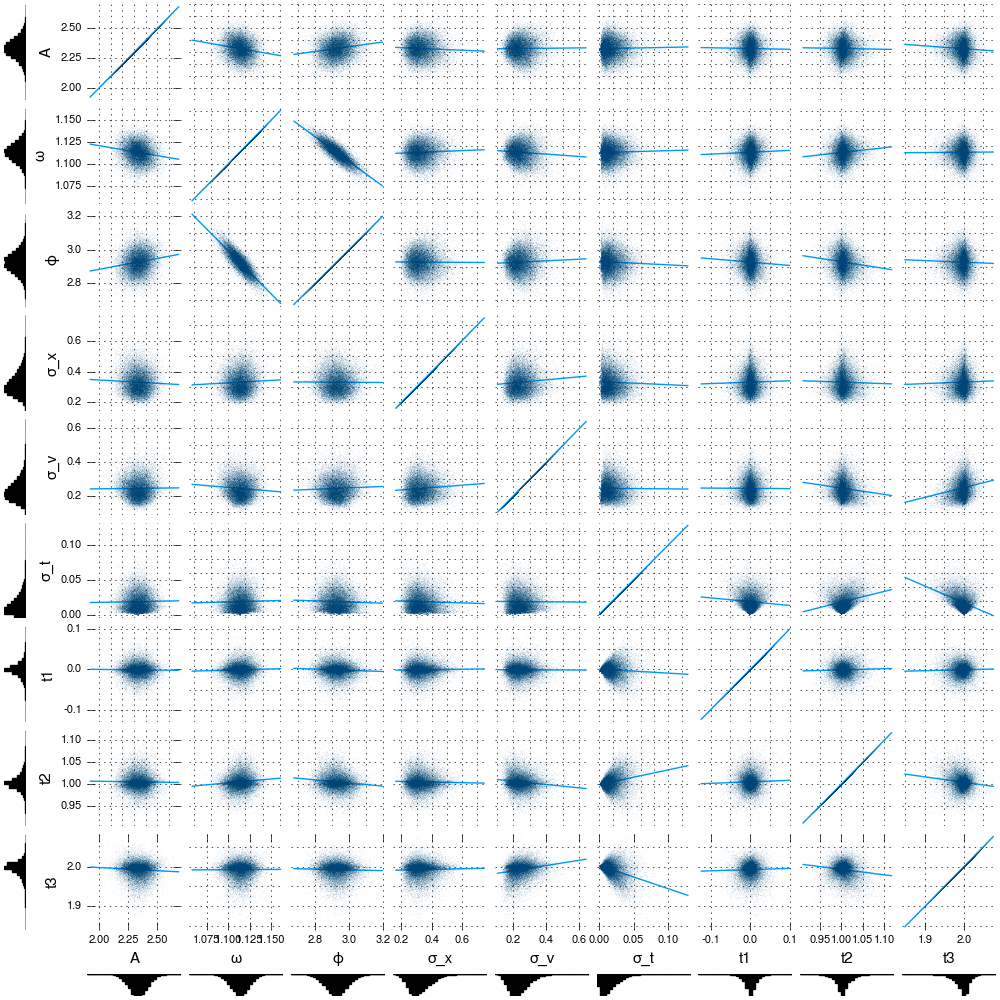

In [9]:
np = 9
cornerplot(thetas_e[1:np,:]', label=varnames[1:np], size=(1000,1000))

## Making predictions

This is a bit less nice than the violin plots in the previous example as we can't plot the whole distribution but only some measures of it.


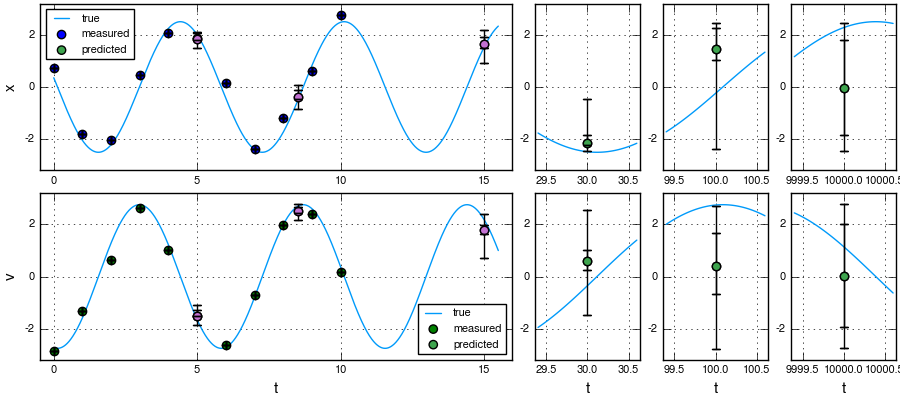

In [10]:
xv_mean_a, xv_std_a, xv_max_a, xv_min_a, xv_q20_a, xv_q80_a = unpack_blob(blobs_m, ts_pred);
x_mean_a,v_mean_a = unpack_xv(xv_mean_a);
ylims=(-3,3)
plotmeasurements(ts_measured, xv_measured, A, ω, ϕ; t_plot=0:0.01:15.5)
scatter!(ts_pred[1:3],xv_mean_a[1:2:5], label="predicted", 
        yerr=[(abs(xv_min_a[i]-xv_mean_a[i]),xv_max_a[i]-xv_mean_a[i]) for i=1:2:5])
scatter!(ts_pred[1:3],xv_mean_a[1:2:5], label="", 
         yerr=[(abs(xv_q20_a[i]-xv_mean_a[i]),xv_q80_a[i]-xv_mean_a[i]) for i=1:2:5])
ylims!(ylims)
p=scatter!(ts_pred[1:3],xv_mean_a[2:2:6], label="predicted", subplot=2,
           yerr=[(abs(xv_min_a[i]-xv_mean_a[i]),xv_max_a[i]-xv_mean_a[i]) for i=2:2:6])
p=scatter!(ts_pred[1:3],xv_mean_a[2:2:6], label="",  subplot=2,
           yerr=[(abs(xv_q20_a[i]-xv_mean_a[i]),xv_q80_a[i]-xv_mean_a[i]) for i=2:2:6])
ylims!(ylims)
# the predictions far off in separtate windows
ps =[]
for i in 4:6
    tp = ts_pred[i]
    t_plot = tp-.6:0.01:tp+.6
    x_plot,v_plot = asol(t_plot,A,ω,ϕ)
    p1=plot(t_plot, x_plot, label="")
    scatter!(ts_pred[i:i],xv_mean_a[2i-1:2i-1], label="",
             yerr=(abs(xv_min_a[2i-1]-xv_mean_a[2i-1]),xv_max_a[2i-1]-xv_mean_a[2i-1]) )
    scatter!(ts_pred[i:i],xv_mean_a[2i-1:2i-1], label="",
             yerr=(abs(xv_q20_a[2i-1]-xv_mean_a[2i-1]),xv_q80_a[2i-1]-xv_mean_a[2i-1]) )
    ylims!(ylims)

    p2=plot(t_plot, v_plot, label="",  xlabel="t")
    scatter!(ts_pred[i:i],xv_mean_a[2i:2i], label="",
            yerr=(abs(xv_min_a[2i]-xv_mean_a[2i]),xv_max_a[2i]-xv_mean_a[2i]) )
    scatter!(ts_pred[i:i],xv_mean_a[2i:2i], label="",
            yerr=(abs(xv_q20_a[2i]-xv_mean_a[2i]),xv_q80_a[2i]-xv_mean_a[2i]) )

    ylims!(ylims)
    push!(ps,plot(p1,p2,layout=(2,1)) )
    
end
widths = [0.6, 0.4/3, 0.4/3, 0.4/3]
plot(p,ps..., layout=grid(1,4, widths=widths), size=(900,400))

The plot displays the "truth" as blue line, measurements as blue and brown dots.  The prediction means are the green dots with double error bars: the wider error bars are `(min,max)`, the smaller are 20%-80% quantile.